# Custom GP modeling for BO

In [1]:
# Ignore all warnings
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import pandas as pd
import torch
from xopt.vocs import VOCS

my_vocs = VOCS(
    variables = {"x":[0,1]},
    objectives = {"y":"MAXIMIZE"},
    constraints = {"c": ["LESS_THAN", 0]}
)


<AxesSubplot: >

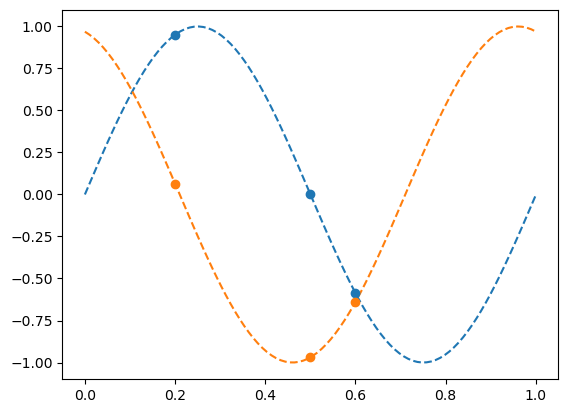

In [2]:
# define test functions
def y(x):
    return torch.sin(2*3.14*x)

def c(x):
    return torch.cos(2*3.14*x + 0.25)

test_x = torch.linspace(*torch.tensor(my_vocs.bounds.flatten()), 100)

# define training data to pass to the generator
train_x = torch.tensor((0.2,0.5, 0.6))
train_y = y(train_x)
train_c = c(train_x)

training_data = pd.DataFrame(
    {"x": train_x.numpy(), "y": train_y.numpy(), "c": train_c}
)

def plot_ground_truth():
    fig,ax = plt.subplots()
    ax.plot(test_x, y(test_x),'--C0')
    ax.plot(test_x, c(test_x),'--C1')
    ax.plot(train_x, train_y,'oC0')
    ax.plot(train_x, train_c,'oC1')

    return ax
plot_ground_truth()

# Custom Model definition
In this example we know that the target optimization function is periodic, so it
makes sense to use a periodic kernel for the GP model with no noise. Here we define a
function to create that model. Note that we can use helper functions provided by Xopt to
compose parts model (in this case a standard GP model for the constraints).

In [3]:
from xopt.generators.bayesian.models.standard import create_constraint_models
from gpytorch import ExactMarginalLogLikelihood
from gpytorch.kernels import PeriodicKernel, ScaleKernel
from botorch.models.transforms import Normalize, Standardize
from botorch import fit_gpytorch_model
from botorch.models import ModelListGP, SingleTaskGP
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.priors import GammaPrior


def create_periodic_model(data, vocs):
    tkwargs = {"dtype": torch.double, "device": "cpu"}
    input_data, objective_data, constraint_data = vocs.extract_data(data)
    train_X = torch.tensor(input_data.to_numpy(), **tkwargs)

    input_transform = Normalize(
        vocs.n_variables, bounds=torch.tensor(vocs.bounds, **tkwargs)
    )

    objective_models = []

    # create models for objective(s)
    for name in objective_data.keys():
        train_Y = torch.tensor(objective_data[name].to_numpy(), **tkwargs).unsqueeze(-1)

        kernel = ScaleKernel(PeriodicKernel())
        likelihood = GaussianLikelihood(noise_prior=GammaPrior(1.0, 10.0))

        objective_models.append(
            SingleTaskGP(
                train_X,
                train_Y,
                input_transform=input_transform,
                outcome_transform=Standardize(1),
                likelihood=likelihood,
                covar_module=kernel,
            )
        )
        mll = ExactMarginalLogLikelihood(objective_models[-1].likelihood, objective_models[-1])
        fit_gpytorch_model(mll)

    # create models for constraint(s)
    constraint_models = create_constraint_models(
        input_data,
        constraint_data,
        input_transform,
        tkwargs,
        use_low_noise_prior=True
    )

    return ModelListGP(*objective_models, *constraint_models)

# Create generator using the custom model

In [4]:
from xopt.generators.bayesian.expected_improvement import ExpectedImprovementGenerator
from xopt.generators.bayesian.options import ModelOptions
from xopt.generators.bayesian.expected_improvement import BayesianOptions

# note the creation of options beforehand
model_options = ModelOptions(function=create_periodic_model)
generator_options = BayesianOptions(model=model_options)
generator = ExpectedImprovementGenerator(my_vocs, options=generator_options)

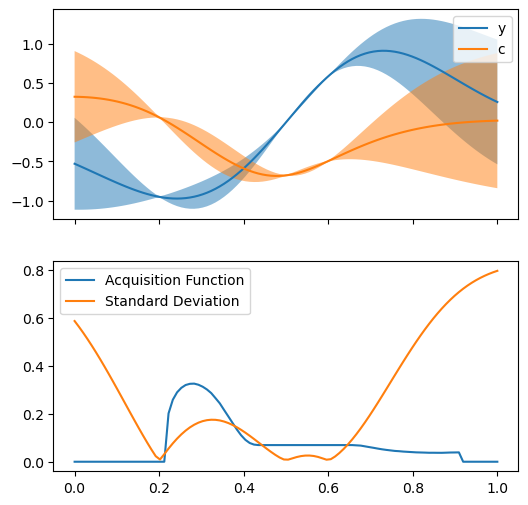

In [5]:
# view custom model from data
generator.add_data(training_data)
model = generator.train_model()

fig,ax = plt.subplots(2,1, sharex="all")
fig.set_size_inches(6,6)
with torch.no_grad():
    post = model.posterior(test_x.reshape(-1,1,1))
    mean = post.mean
    std = torch.sqrt(post.variance)

    l = mean - std
    u = mean + std

    acq = generator.get_acquisition(model)(test_x.reshape(-1,1,1).double())

    for i in range(mean.shape[-1]):
        ax[0].plot(test_x, mean[...,i],f"C{i}", label=generator.vocs.output_names[i])
        ax[0].fill_between(test_x, l[...,i].flatten(), u[...,i].flatten(), alpha=0.5)
    ax[0].legend()

    ax[1].plot(test_x, acq, label='Acquisition Function')
    ax[1].plot(test_x, std[...,0], label='Standard Deviation')
    ax[1].legend()

In [6]:
# get the next point from the generator
generator.generate(1)

,x
0,0.279192
